# 使用 diffusers

写程序，通过 [huggingface diffusers](https://huggingface.co/docs/diffusers/index) 库，调用图像生成模型。

这里为了简化，暂时不使用 Stable Diffusion 模型。

本文参考 https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

## 使用 pipeline

In [1]:
from diffusers import DDPMPipeline

model_path="/models/ddpm-celebahq-256"
image_pipe = DDPMPipeline.from_pretrained(model_path)
image_pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "/models/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

model 在 pipleline 创建过程中加载。

下面生成图片。

  0%|          | 0/1000 [00:00<?, ?it/s]

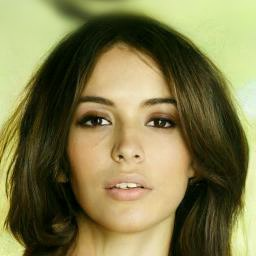

In [2]:
images = image_pipe().images
images[0]

## 使用 model

加载模型：

In [1]:
from diffusers import UNet2DModel

model_path="/models/ddpm-church-256"
model = UNet2DModel.from_pretrained(model_path)

In [2]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsampl

In [3]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'si

In [4]:
model_random = UNet2DModel(**model.config)

In [5]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

In [6]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

## 使用 scheduler

In [7]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(model_path)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:240: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [8]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('_use_default_values',
             ['prediction_type',
              'steps_offset',
              'dynamic_thresholding_ratio',
              'sample_max_value',
              'thresholding',
              'timestep_spacing',
              'clip_sample_range']),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

In [9]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [10]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

  5% 48/1000 [00:02<00:53, 17.95it/s]

'Image at step 50'

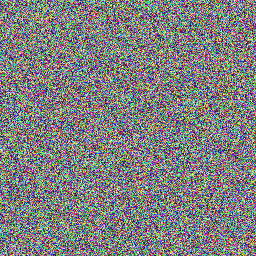

 10% 99/1000 [00:05<00:50, 17.94it/s]

'Image at step 100'

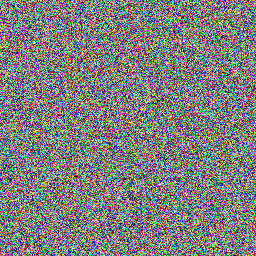

 15% 149/1000 [00:08<00:47, 17.94it/s]

'Image at step 150'

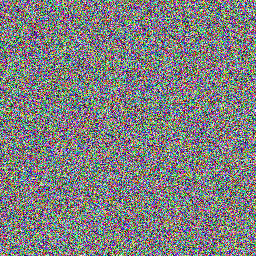

 20% 199/1000 [00:11<00:44, 17.96it/s]

'Image at step 200'

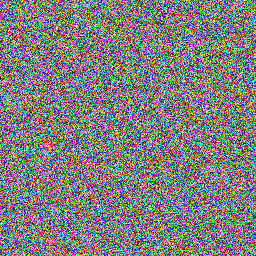

 25% 249/1000 [00:14<00:41, 17.96it/s]

'Image at step 250'

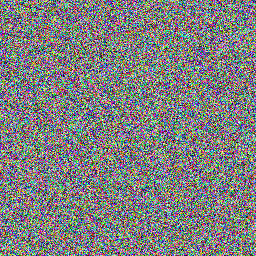

 30% 299/1000 [00:16<00:39, 17.94it/s]

'Image at step 300'

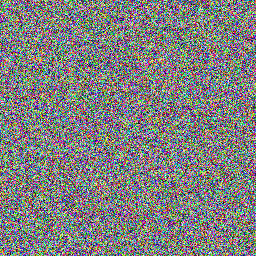

 35% 349/1000 [00:19<00:36, 17.94it/s]

'Image at step 350'

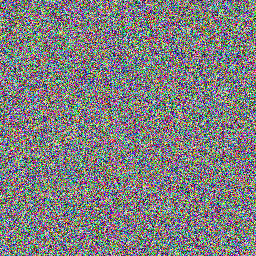

 40% 399/1000 [00:22<00:33, 17.94it/s]

'Image at step 400'

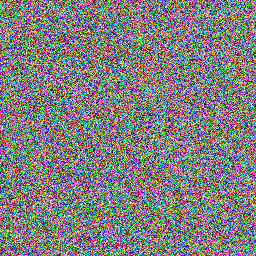

 45% 449/1000 [00:25<00:30, 17.93it/s]

'Image at step 450'

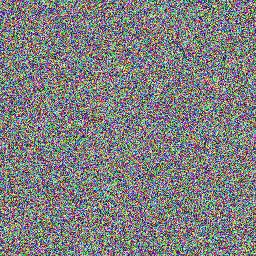

 50% 499/1000 [00:28<00:27, 17.94it/s]

'Image at step 500'

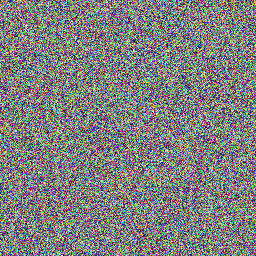

 55% 549/1000 [00:30<00:25, 17.96it/s]

'Image at step 550'

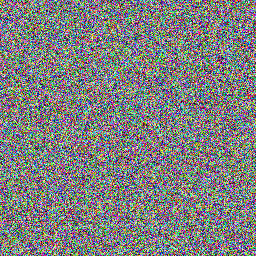

 60% 599/1000 [00:33<00:22, 17.92it/s]

'Image at step 600'

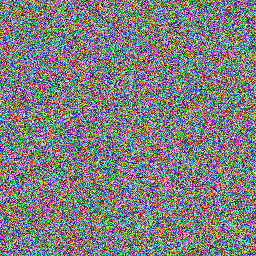

 65% 649/1000 [00:36<00:19, 17.94it/s]

'Image at step 650'

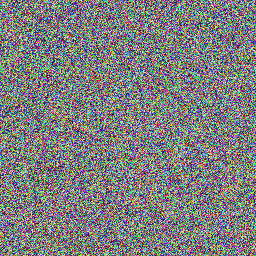

 70% 699/1000 [00:39<00:16, 17.95it/s]

'Image at step 700'

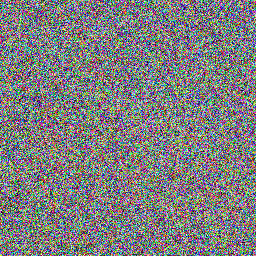

 75% 749/1000 [00:42<00:13, 17.94it/s]

'Image at step 750'

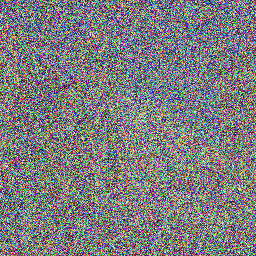

 80% 799/1000 [00:44<00:11, 17.94it/s]

'Image at step 800'

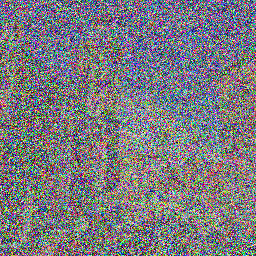

 85% 849/1000 [00:47<00:08, 17.96it/s]

'Image at step 850'

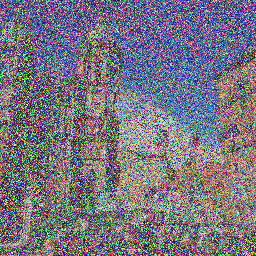

 90% 899/1000 [00:50<00:05, 17.90it/s]

'Image at step 900'

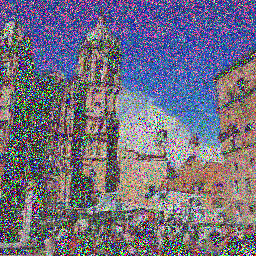

 95% 949/1000 [00:53<00:02, 17.95it/s]

'Image at step 950'

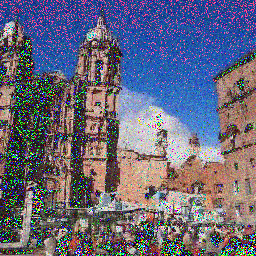

100% 999/1000 [00:56<00:00, 17.95it/s]

'Image at step 1000'

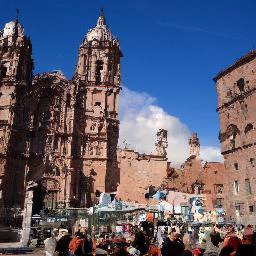

100% 1000/1000 [00:56<00:00, 17.78it/s]


In [11]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)